# Лабораторная №7 "Автоассоциативные сети с узким горлом"

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils

from torch.utils.data.dataloader import default_collate
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange

*Вариант* № 17

Красоткин Семён (М80-408Б-19)

## Цель работы

Исследование свойств автоассоциативных сетей с узким горлом, алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного анализа главных компонент набора данных.

Возьму GPU из коллаба.

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [68]:
CIFAR_VARIANT = 17 % 10
CIFAR_ID = 3

Возьму Cifar10 из датасетов torchvision.

In [69]:
cifar10_data = datasets.CIFAR10( root="data", train=False, download=True, transform=ToTensor())

Files already downloaded and verified


In [70]:
cifar10_images = [[] for _ in range(10)]
for elem in cifar10_data:
    (x, y) = elem
    cifar10_images[y].append(2 * x - 1)

In [71]:
def display_images(data, max_n=8, titles=None):
    n = min(max_n, len(data))
    fig, ax = plt.subplots(1, n, figsize=(2 * n, 2))
    for i in range(n):
        img = data[i].detach().cpu().numpy()
        img = (img + 1) / 2
        ax[i].imshow(img.transpose(1, 2, 0))
        ax[i].axis("off")
        if titles != None:
            ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

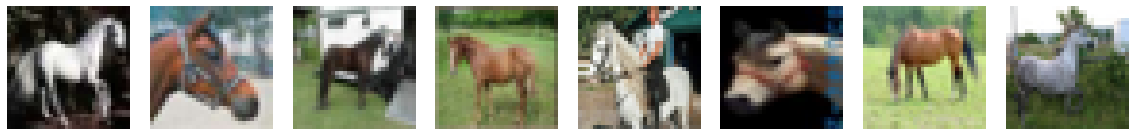

In [72]:
display_images(cifar10_images[CIFAR_VARIANT])

In [97]:
DIM1 = 32 * 32 * 3
DIM2 = 2**11
DIM3 = 2**10
DIM4 = 2**7

encoder = nn.Sequential(
    nn.Linear(DIM1, DIM2),
    nn.Tanh(),
    nn.Linear(DIM2, DIM3),
    nn.Tanh(),
    nn.Linear(DIM3, DIM4),
    nn.Tanh()
).cuda()

decoder = nn.Sequential(
    nn.Linear(DIM4, DIM3),
    nn.Tanh(),
    nn.Linear(DIM3, DIM2),
    nn.Tanh(),
    nn.Linear(DIM2, DIM1),
    nn.Tanh(),
).cuda()

crit = torch.nn.MSELoss()


In [74]:
def fit_enc_dec(model_enc, model_dec, imgs, epoches=10, lr=1e-3):
    model_enc.train()
    model_dec.train()
    optim_enc = torch.optim.Adam(model_enc.parameters(), lr=lr)
    optim_dec = torch.optim.Adam(model_dec.parameters(), lr=lr)

    n = len(imgs)
    for i in range(n):
        imgs[i] = imgs[i].flatten().to(device)

    h = {"mse": []}
    for epoch in trange(epoches, desc="Traning autoencoder", ascii=True):
        train_loss_ep = 0.0
        for img in imgs:
            features = model_enc(img)
            img_out = model_dec(features)
            loss = crit(img, img_out)
            loss.backward()

            optim_dec.step()
            optim_enc.step()

            optim_dec.zero_grad()
            optim_enc.zero_grad()

            train_loss_ep += loss.detach().cpu().item() / n

        h["mse"].append(train_loss_ep)

    figure = plt.figure(figsize=(16, 9))
    axes = figure.add_subplot(111)
    plt.plot(h["mse"])
    plt.ylabel("MSE")
    plt.xlabel("Эпохи")
    plt.show()

    del optim_enc
    del optim_dec

    if device == "cuda":
        torch.cuda.empty_cache()


Traning autoencoder: 100%|##########| 200/200 [27:06<00:00,  8.13s/it]


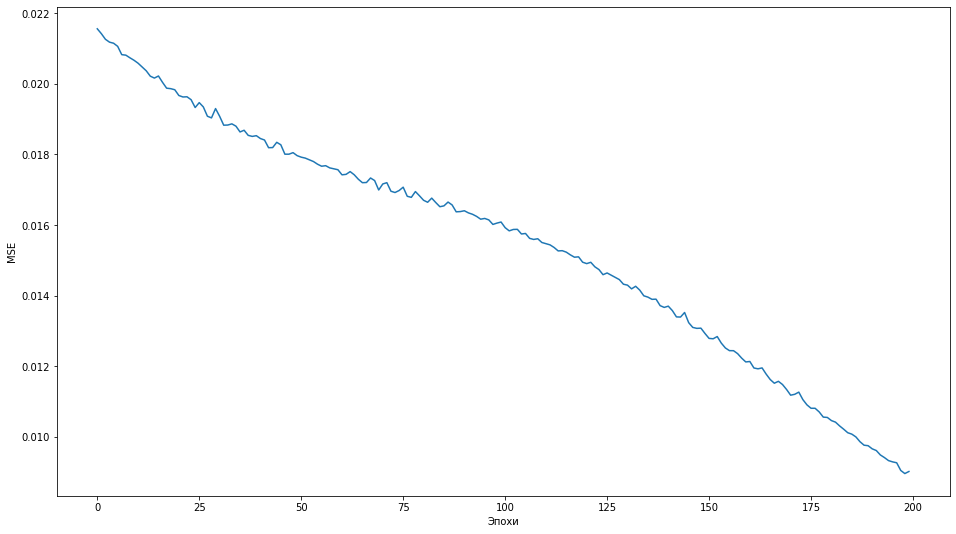

In [100]:
fit_enc_dec(encoder, decoder, cifar10_images[CIFAR_VARIANT], epoches = 200, lr=1e-5)

In [93]:
def draw_enc_dec(model_enc, model_dec, img, n_features, n_imgs=6):
    model_enc.eval()
    model_dec.eval()

    img = img.flatten().to(device)

    features = model_enc(img)
    img_out = model_dec(features)

    imgs = [img]
    imgs.append(img_out)

    n = 2 + n_imgs

    for _ in range(n_imgs):
        ids = np.random.randint(0, DIM4, n_features)
        vals = 2 * np.random.rand(n_features) - 1

        features_changed = features.detach().clone()
        for j, elem in enumerate(ids):
            features_changed[elem] = vals[j]
        imgs.append(model_dec(features_changed))

    for i in range(n):
        imgs[i] = imgs[i].reshape(3, 32, 32)

    titles = ["Модифицированный\nвектор"]
    titles = ["Исходное\nизображение", "Выход\nавтокодировщика"] + titles * n_imgs
    display_images(imgs, n, titles=titles)

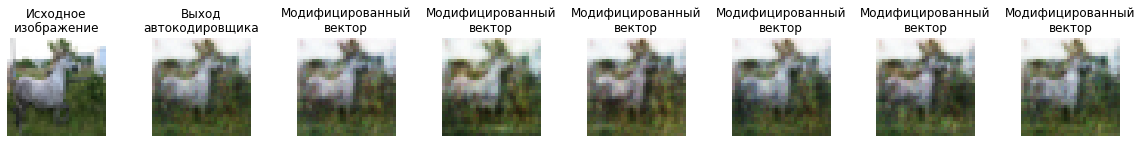

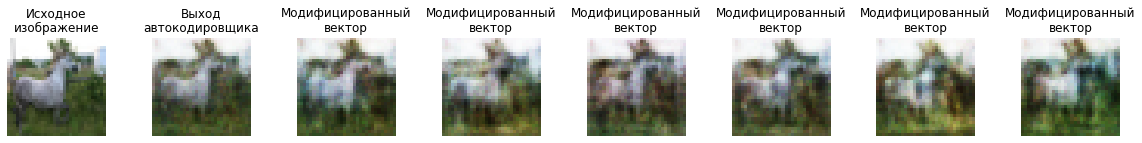

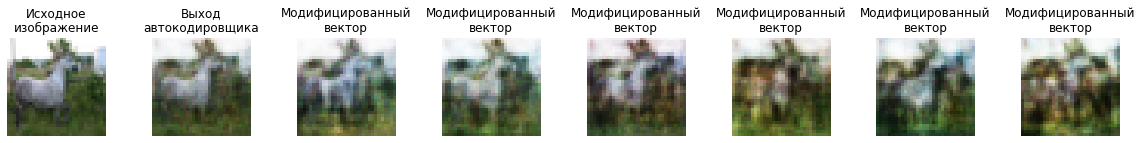

In [101]:
for i in range(len([4, 8, 16])):
  draw_enc_dec(encoder, decoder, cifar10_images[CIFAR_VARIANT][CIFAR_ID], [4, 8, 16][i])

# Выводы
В ходе выполнения 7-й лабораторной работы исследовал архитектуру автоэнкодера и набор данных CIFAR-10. Произвёл обучение на лошадях.